In [136]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Helper Functions

In [137]:
def annotate(plot, x, y):
	for p in plot.patches:
		plot.annotate(f'{p.get_height():.1f}', (p.get_x() + x, p.get_height() + y))

In [138]:
def save_fig(df_plot, path):
	df_plot.get_figure().savefig(path, bbox_inches='tight')

## Load Data

In [139]:
data_dir = 'data/cleaned'
joe = f'{data_dir}/tournament_results_short_formatted.csv'
m1 = f'{data_dir}/tournament_m1_results_short_formatted.csv'
gcp = f'{data_dir}/tournament_g1_gcp_short_formatted.csv'

In [140]:
gcp_df = pd.read_csv(gcp)
m1_df = pd.read_csv(m1)
joe_df = pd.read_csv(joe)

In [141]:
gcp_maps = list(set(gcp_df['map'].values.tolist()))
# gcp_maps = ['maps/g4/n.json', 'maps/g8/risk_map.json', 'maps/g3/g3_tournament.json', 'maps/g4/jump.json']
print(f"GCP rerun maps: {gcp_maps}")

GCP rerun maps: ['maps/g4/jump.json', 'maps/g8/risk_map.json', 'maps/g3/g3_tournament.json', '2021_maps/g2/spider_par6.json', 'maps/g4/n.json']


In [142]:
def filter_by_maps(df, maps, player='Group 1'):
	filter = None

	for m in maps:
		if filter is None:
			filter = df['map'] == m
		else:
			filter = filter | (df['map'] == m)
	
	return df[filter & (df['player_names'] == player)]

In [143]:
sources = ['class_tournament', 'm1', 'GCP']
joe_df = filter_by_maps(joe_df, gcp_maps).assign(source=sources[0])
m1_df = filter_by_maps(m1_df, gcp_maps).assign(source=sources[1])
gcp_df = filter_by_maps(gcp_df, gcp_maps).assign(source=sources[2])

In [144]:
merged_df = pd.concat([joe_df, m1_df, gcp_df])

In [145]:
merged_df.head()

,player_names,map,skills,scores,player_states,penalties,timeout_count,error_count,total_time_sorted,source
242,Group 1,maps/g4/n.json,10,10,1,0,1,0,600.085941,class_tournament
243,Group 1,maps/g4/n.json,10,10,1,0,1,0,600.122326,class_tournament
244,Group 1,maps/g4/n.json,10,10,1,0,1,0,600.098472,class_tournament
245,Group 1,maps/g4/n.json,10,10,1,0,1,0,600.108959,class_tournament
246,Group 1,maps/g4/n.json,25,10,1,0,1,0,600.065955,class_tournament


## Timeouts and Run Time

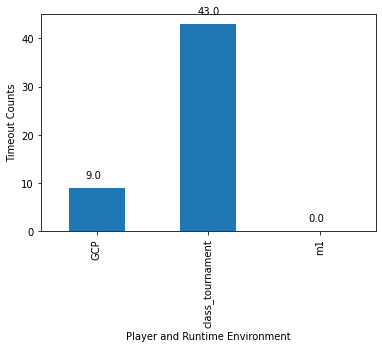

In [146]:
timeout_plot = merged_df.filter(['source', 'timeout_count']).groupby(['source']).sum().reset_index().plot.bar(
	x='source', y='timeout_count', legend=False,
	xlabel='Player and Runtime Environment', ylabel='Timeout Counts'
)
annotate(timeout_plot, 0.15, 2)
save_fig(timeout_plot, 'graphs/g1_timeout_comparison.png')

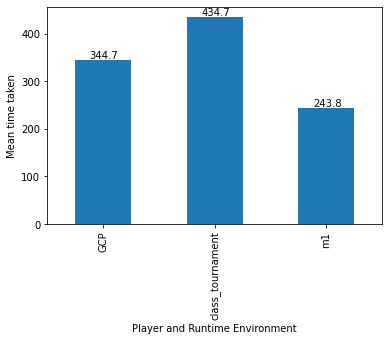

In [147]:
time_plot = merged_df.filter(['source', 'total_time_sorted']).groupby(['source']).mean().reset_index().plot.bar(
	x='source', y='total_time_sorted', legend=False,
	xlabel='Player and Runtime Environment', ylabel='Mean time taken'
)
annotate(time_plot, .13, 3)
save_fig(time_plot, 'graphs/g1_time_comparison.png')

## Scores

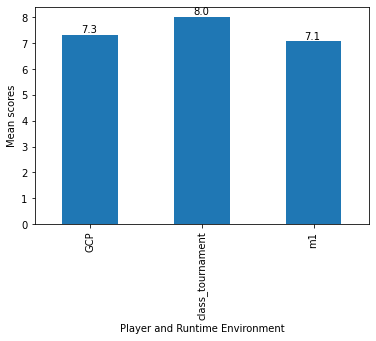

In [148]:
scores_plot = merged_df.filter(['source', 'scores']).groupby(['source']).mean().reset_index().plot.bar(
	x='source', y='scores', legend=False,
	xlabel='Player and Runtime Environment', ylabel='Mean scores'
)
annotate(scores_plot, 0.17, 0.08)
save_fig(scores_plot, 'graphs/g1_scores_comparison.png')

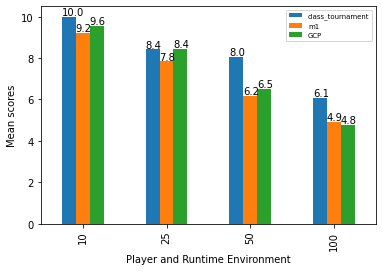

In [149]:
scores_skill_plot = merged_df.filter(['source', 'skills', 'scores']).groupby(['skills', 'source']).mean().reset_index().pivot(
		index='skills', columns='source', values='scores').reset_index() .plot.bar(
		x='skills', y=sources,
		xlabel='Player and Runtime Environment', ylabel='Mean scores')
scores_skill_plot.legend(fontsize='x-small', bbox_to_anchor=(1, 1))
annotate(scores_skill_plot, 0, 0.08)
save_fig(scores_skill_plot, 'graphs/g1_scores_by_skill_comparison.png')

In [150]:
avg_scores_map_skill_df = merged_df.filter(['source', 'map', 'skills', 'scores']).groupby(['map', 'skills', 'source']).mean().reset_index()

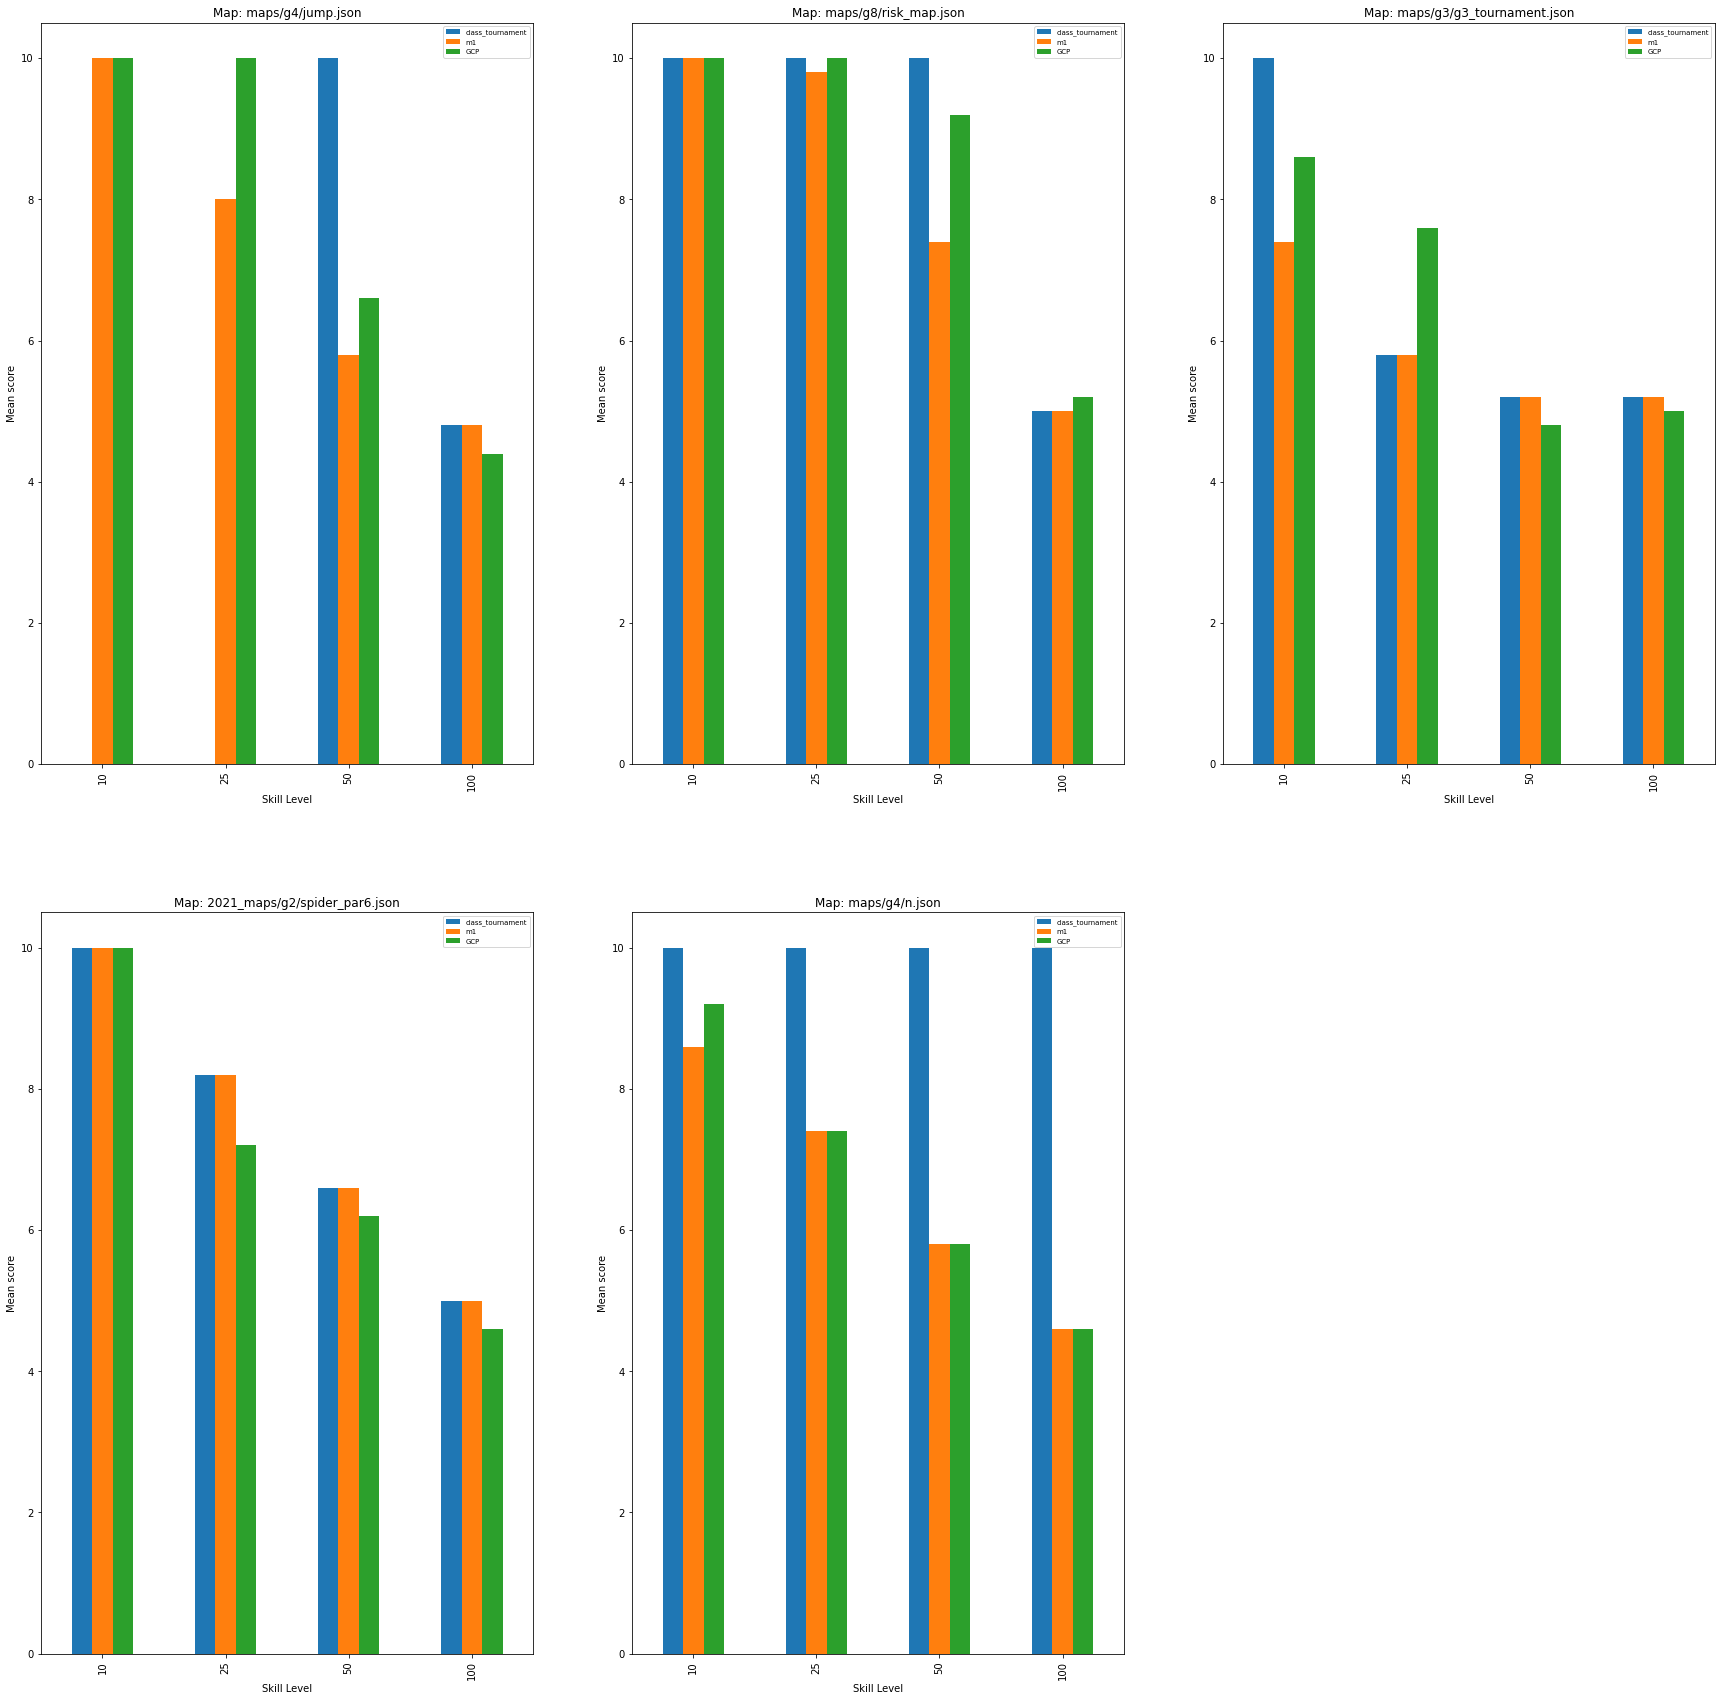

In [151]:
nrow, ncol = 2, 3
map_fig, map_axes = plt.subplots(nrow, ncol, figsize=(30, 30))
map_fig.delaxes(map_axes[1,2])

count = 0
for tmap in gcp_maps:
	map_df = avg_scores_map_skill_df[avg_scores_map_skill_df['map'] == tmap]

	map_df = map_df.pivot(index='skills', columns='source', values='scores').reset_index()
	map_df.plot.bar(
		x='skills', y=sources,
		xlabel='Skill Level', ylabel='Mean score', title=f'Map: {tmap}',
		ax=map_axes[count // ncol, count % ncol])
	map_axes[count // ncol, count % ncol].legend(fontsize='x-small', bbox_to_anchor=(1, 1))
	count += 1

map_fig.savefig('graphs/g1_score_comparison_by_map_skill.png')